# Introduction to Quantitative Trading - Building a Machine Learning Model

## Importing some libraries

In [39]:
import pandas as pd
import yfinance as yf
import numpy as np
import talib as ta
import plotly.express as px
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

np.random.seed(42)
pd.options.mode.chained_assignment = None

## Defining the parameters

In [40]:
# Get the data for the stock
start_date = '2012-01-01'
end_train = '2017-12-31'
end_date = '2023-12-31'
ticker = 'AAPL'

df = yf.download(ticker, start=start_date, end=end_date)

/Users/gw/workspace/quantitative-finance/venv/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning:

The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.

[*********************100%%**********************]  1 of 1 completed


## Data Preprocessing

In [41]:
df["Adj Low"] = df["Low"] - (df["Close"]-df["Adj Close"])
df["Adj High"] = df["High"] - (df["Close"]-df["Adj Close"])

In [42]:
df["Returns"] = df["Adj Close"].pct_change()

df["Target"] = df["Returns"].shift(-1)
df["Target_cat"] = np.where(df["Target"] > 0, 1, 0)

## Feature Engineering

In [43]:
df["std15"] = df["Adj Close"].rolling(15).std()
df["moving_average"] = df["Adj Close"].rolling(15).mean()


df["zscore"] = (df["Adj Close"]-df["moving_average"])/df["std15"]
df["aroon"] = ta.AROONOSC(df["Adj High"], df["Adj Low"], timeperiod=14)

df["price_trend"] = df["Returns"].shift().rolling(4).sum()

In [44]:
df["zscore"] = pd.qcut(df["zscore"], 6, labels = False)
df["aroon"] = pd.qcut(df["aroon"], 4, labels = False)
df["price_trend"] = pd.qcut(df["price_trend"], 6, labels = False)

In [45]:
# let's drop the NaN values resulting from the rolling calculations
df = df.dropna()

In [46]:
features = ["aroon", "zscore", "price_trend"]

In [47]:
df[features].head()

,aroon,zscore,price_trend
Date,,,
2012-01-24,2.0,2.0,3.0
2012-01-25,3.0,5.0,1.0
2012-01-26,3.0,5.0,5.0
2012-01-27,2.0,5.0,5.0
2012-01-30,2.0,5.0,5.0


## Building the Model

In [48]:
# train test split
X_train, X_test = df[features].loc[start_date:end_train], df[features].loc[end_train:end_date]
y_train, y_test = df["Target_cat"].loc[start_date:end_train], df["Target_cat"].loc[end_train:end_date]

In [49]:
X_train.head()

,aroon,zscore,price_trend
Date,,,
2012-01-24,2.0,2.0,3.0
2012-01-25,3.0,5.0,1.0
2012-01-26,3.0,5.0,5.0
2012-01-27,2.0,5.0,5.0
2012-01-30,2.0,5.0,5.0


We will be using the XGBoost model as our classification model. XGBoost is a popular and efficient implementation of the gradient boosting algorithm. We will fit the model using the train data and evaluate its performance using the test data.

In [50]:
model = XGBClassifier()

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Evaluating the Model

In [51]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.39      0.43       704
           1       0.54      0.64      0.59       804

    accuracy                           0.52      1508
   macro avg       0.52      0.51      0.51      1508
weighted avg       0.52      0.52      0.52      1508


## Backtesting the Model

In [52]:
df["train_test"] = np.where(df.index > end_train, "Test", "Train")

y_pred_all = model.predict(df[features])
df["Signal"] = np.where(y_pred_all == 1, 1, -1)

df["Model_Returns"] = df["Signal"] * df["Target"]

/Users/gw/workspace/quantitative-finance/venv/lib/python3.9/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



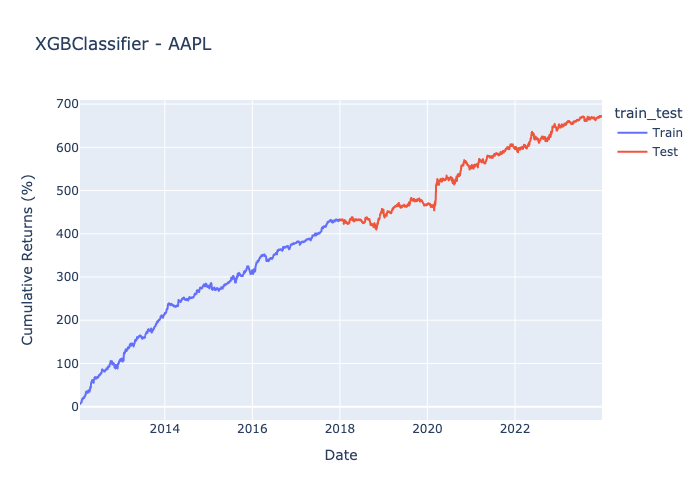

In [53]:
fig = px.line(df, x=df.index, y=df["Model_Returns"].cumsum()*100, color="train_test",
              labels={"y": "Cumulative Returns (%)"},
              title=f"{model.__class__.__name__} - {ticker}",
              line_shape="linear")

fig.show("png")

In [54]:
# calculate the yearly rate of return on the test data
df_test = df.loc[end_train:]
df_test["Year"] = df_test.index.year

# plot the returns by year
returns_by_year = df_test.groupby("Year")["Model_Returns"].sum()*100
px.bar(returns_by_year, labels={"value": "Returns (%)", "Year": "Year"},
       title=f"{model.__class__.__name__} - {ticker} - Test Data")

In [55]:
print("Total Return: ", df_test["Model_Returns"].sum()*100)
print("Mean: ", returns_by_year.mean())

Total Return:  240.9488310935389
Mean:  40.15813851558982
